In [1]:
import pandas as pd
import numpy as np

In [2]:
#1.1 데이터 불러오기
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

In [3]:
#1.2 단위 수정
train_x = train.drop(['price'], axis = 1)
train_y = train.loc[:, ['price']]
train_x.head()

,dong,apt,exclusive_use_area,floor,transaction_year,until_trans,sin_date,cos_date
0,사직동,광화문풍림스페이스본(9-0),95.88,6,0,5,-1.000000e+00,-1.836970e-16
1,사직동,광화문풍림스페이스본(9-0),108.55,11,0,5,-2.449294e-16,1.000000e+00
2,사직동,광화문풍림스페이스본(9-0),94.51,1,0,5,-2.449294e-16,1.000000e+00
3,수송동,로얄팰리스스위트,42.87,8,0,8,-1.000000e+00,-1.836970e-16
4,수송동,로얄팰리스스위트,39.67,15,0,8,1.000000e+00,3.061617e-16


In [4]:
#1.3 validation set 분할 - 첫번째
from sklearn.model_selection import train_test_split
train_tune_x, val_x, train_tune_y, val_y = train_test_split(train_x, train_y, test_size=0.2, shuffle=True, random_state=34)

In [5]:
#1.4 질문
#관측된 시간이 존재하는 상황에서 데이터를 나눌 경우 validation은 not trivial하기에 
#랜덤으로 샘플을 고르지 못하고, 그들을 train과 test로 지정할 수 없다. 
#그 이유는 미래의 값을 사용해서 과거의 값을 예측하는 것은 이치에 맞지 않기 때문이다
#따라서 관찰 사이에는 시간적 종속성이 있으며 테스트 중에는 해당 관계를 잘 유지해야한다.
#이를 해결하기 위해서는 롤링 기반 교차 검증을 사용하면 된다. 

In [6]:
#1.5 validation set 분할 - 두번째
val_x = train_x[train['transaction_year'] == 4]
val_y = train_y[train['transaction_year'] == 4]
train_tune_x = train_x[train['transaction_year'] < 4]
train_tune_y = train_y[train['transaction_year'] < 4]
train_tune_x.head()

,dong,apt,exclusive_use_area,floor,transaction_year,until_trans,sin_date,cos_date
0,사직동,광화문풍림스페이스본(9-0),95.88,6,0,5,-1.000000e+00,-1.836970e-16
1,사직동,광화문풍림스페이스본(9-0),108.55,11,0,5,-2.449294e-16,1.000000e+00
2,사직동,광화문풍림스페이스본(9-0),94.51,1,0,5,-2.449294e-16,1.000000e+00
3,수송동,로얄팰리스스위트,42.87,8,0,8,-1.000000e+00,-1.836970e-16
4,수송동,로얄팰리스스위트,39.67,15,0,8,1.000000e+00,3.061617e-16


In [7]:
#1.5 캣부스트 인코딩 전에
! pip install category_encoders

In [8]:
from category_encoders.cat_boost import CatBoostEncoder

In [9]:
#1.6 캣부스트 인코딩
def catboost_encoder(train_x, train_y, test_x):
  cate_var = list(train_x.select_dtypes(include=['object']))
  encoder = CatBoostEncoder()
  cbe_train_x = encoder.fit_transform(train_x[cate_var], train_y)
  cbe_test_x = encoder.transform(test_x[cate_var])
  cbe_train_result = (np.concatenate((cbe_train_x, train_x.loc[:,['exclusive_use_area', 'floor', 'transaction_year', 
                                                                  'until_trans', 'sin_time', 'cos_time']]), axis=1))
  cbe_test_result = (np.concatenate((cbe_test_x, test_x.loc[:,['exclusive_use_area', 'floor', 'transaction_year', 
                                                               'until_trans', 'sin_time', 'cos_time']]), axis=1))
  cbe_final_train = pd.DataFrame(cbe_train_result, columns= train_x.columns)
  cbe_final_test = pd.DataFrame(cbe_test_result, columns= test_x.columns)
  return(cbe_final_train, cbe_final_test)

In [10]:
feature_list = list(train_tune_x.columns)

CBE_encoder = CatBoostEncoder()
train_tune_cbe = CBE_encoder.fit_transform(train_tune_x[feature_list], train_tune_y)
val_cbe = CBE_encoder.transform(val_x[feature_list])

val_cbe.head()

,dong,apt,exclusive_use_area,floor,transaction_year,until_trans,sin_date,cos_date
2451,89176.597368,86280.203194,107.91,14,4,9,-1.000000e+00,-1.836970e-16
2452,89176.597368,86280.203194,151.81,10,4,9,-1.000000e+00,-1.836970e-16
2453,89176.597368,86280.203194,94.51,2,4,9,-2.449294e-16,1.000000e+00
2454,89176.597368,86280.203194,94.28,12,4,9,-2.449294e-16,1.000000e+00
2455,103789.156533,107170.755379,145.96,13,4,13,-1.000000e+00,-1.836970e-16


<AxesSubplot:>

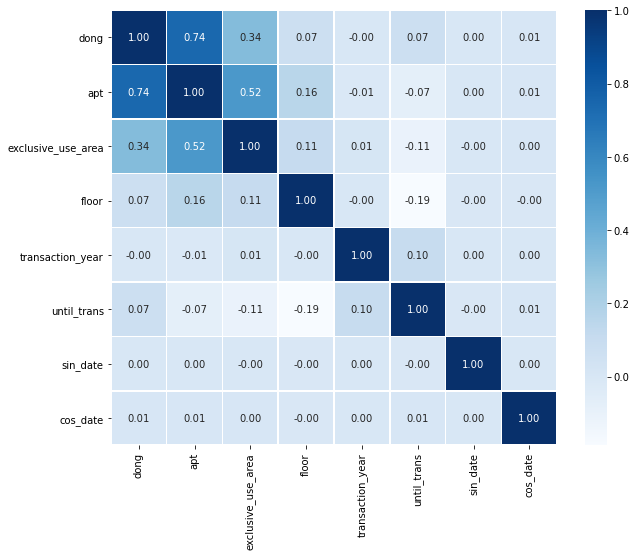

In [11]:
#2.1 릿지회귀-상관계수 플랏
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,8))
sns.heatmap(data = train_tune_cbe.corr(), annot=True, 
fmt = '.2f', linewidths=.5, cmap='Blues')

In [12]:
#2.2 해석과 무관하게 일단 릿지 튜닝
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from math import sqrt

best_ridge_score = 1000000
each_score = []
alpha_ridge = [0.000001,0.00001, 0.0001, 0.001, 0.01]

for alpha1 in alpha_ridge:
    ridge_reg = Ridge(alpha = alpha1)
    ridge_reg.fit(train_tune_cbe, train_tune_y)
    pred_y = ridge_reg.predict(val_cbe)
    rmse_ridge = sqrt(mean_squared_error(val_y, pred_y))
    
    each_score.append(rmse_ridge)
    
        # RMSE가 더 작으면 기록합니다.
    if rmse_ridge < best_ridge_score:
        best_ridge_score = rmse_ridge
        best_parameters = {'alpha': alpha1}
        
print(best_parameters)
print(best_ridge_score)
print(each_score)

{'alpha': 1e-06}
14777.881419493464
[14777.881419493464, 14777.881419502499, 14777.881419592875, 14777.881420496602, 14777.881429533885]


<AxesSubplot:>

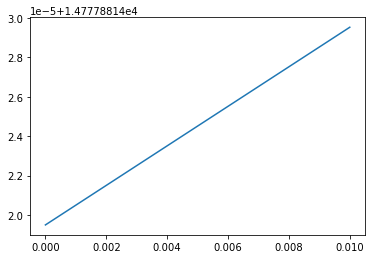

In [13]:
#2.3 튜닝결과 시각화
sns.lineplot(x = alpha_ridge, y = each_score)

In [14]:
#2.4 해석
#릿지에 사용된 알파 값이 크게되면 패널티의 효과가 커지게 되고, 작게되면 그 반대가되는데,
#알파가 0.00001과 0.1의 그래프 폭에 조금 차이가 있어보이지만, 큰 차이를 보이진 않는다.

In [15]:
#2.5 그냥 선형 모형으로!
#릿지는 알파값이 작아지면서 점점 선형 모형에 가까워져야하는데, 알파값이 커도 선형모형과 거의 비슷한 형태를 이루기 때문에,
#단순한 선형모형을 사용하여 RMSE를 사용하는 것이 더 나을 것 같다.

from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(train_tune_cbe, train_tune_y)
pred_y = lin_reg.predict(val_cbe)
rmse_lin = sqrt(mean_squared_error(val_y, pred_y))
print('RMSE of linear regression is', rmse_lin)

RMSE of linear regression is 14777.881419492394


In [16]:
#3 LightGBM
! pip install lightgbm

In [17]:
#3.1 LightGBM 이해
#특징: 기존의 gradient boosting 알고리즘과는 다르게 리프 중심 트리 분할을 사용하여서 트리의 깊이를 줄이고 균형 트리 분할을 사용한다.
#장점: 큰 사이즈의 데이터를 다루는 반면에, 메모리 사용량이 작고, 카테고리형 피처의 자동 변환과 최적 분할이 가능하다.
#단점: 적은 데이터 세트에 적용할 경우 과적합이 발생할 수 있다. 따라서, 데이터의 개수가 10000개 이상일때 사용하는 것이 좋다.

In [18]:
#3.2 LGBM 튜닝
import lightgbm as lgb
from lightgbm import LGBMModel,LGBMRegressor

best_lgbm_score = 1000000
each_score = []
lr_lgbm = [0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 0.99]

for lr in lr_lgbm:
    lgbm_reg = LGBMRegressor(learning_rate = lr)
    lgbm_reg.fit(train_tune_cbe, train_tune_y)
    pred_y = lgbm_reg.predict(val_cbe)
    rmse_lgbm = sqrt(mean_squared_error(val_y, pred_y))
    
    each_score.append(rmse_lgbm)
    
        # RMSE가 더 작으면 기록합니다.
    if rmse_lgbm < best_lgbm_score:
        best_lgbm_score = rmse_lgbm
        best_parameters = {'learning_rate': lr}
        
print(best_parameters)
print(best_lgbm_score)
print(each_score)

{'learning_rate': 0.3}
11203.645981790534
[20425.56868365825, 12022.076838668658, 11590.66141311688, 11203.645981790534, 11529.176861780024, 13135.209268880475, 12646.056552072083]


<AxesSubplot:>

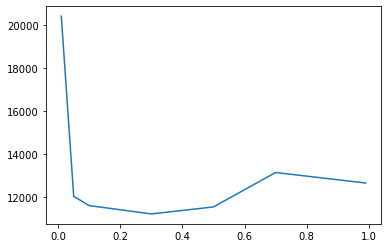

In [19]:
#3.3 튜닝결과 시각화
sns.lineplot(x = lr_lgbm, y = each_score)

In [20]:
#3.4 튜닝에 대하여 알아보자
#그리드 서치는 탐색의 대상이 되는 특정 구간 내의 후보 hyperparameter 값들을 일정한 간격을 두고 선정하여, 이들 각각에 대하여 측정한 성능 결과를 기록한 뒤, 가장 높은 성능을 발휘했던 hyperparameter 값을 선정하는 방법.
#즉, 모든 parameter의 경우의 수에 대해 CV 결과가 가장 좋은 parameter를 고르는 방법
#그리드 서치 장점: 좀 더 균등하고 전역적인 탐색이 가능하다.
#그리드 서치 단점: hyperparameter의 개수를 한 번에 여러종류로 가져갈수록, 전체 탐색 시간이 증가함

#랜덤서치는 그리드서치에 비해 불필요한 반복 수행 횟수를 대폭 줄이고, 동시에 정해진 간격사이에 위치한 값들에 대해서도 확률적으로 탐색이 가능하다. 따라서, 최적 hyperparameter 값을 더 빨리 찾을 수 있다.
#즉, 랜덤서치는 모든 간격을 전부 서치하는 대신, 랜덤하게 일부의 parameter 들만 관측한 후, 그 중에서 가장 좋은 parameter를 고른다.
#랜덤서치 장점: 불필요한 탐색을 줄일 수 있다.
#랜덤서치 단점: 사전에 선택된 Parameter를 반영하지 않으므로 탐색속도가 불안정하다.

#Bayesian Optimization은 사전에 선택된 parameter를 반영하여 탐색한다
#장점: 위의 두 서치에 비해 효율적으로 최적값을 찾아낸다.
#단점: 속도가 매우 빠르지는 않다. 

In [21]:
#4.1 test set 불러오기
test= pd.read_csv('test.csv')
test_x = test.drop(['price'], axis = 1)
test_y = test.loc[:, ['price']]

In [22]:
#4.2 캣부스트 인코딩
feature_list = list(train_x.columns)

CBE_encoder = CatBoostEncoder()
train_cbe = CBE_encoder.fit_transform(train_x[feature_list], train_y)
test_cbe = CBE_encoder.transform(test_x[feature_list])


In [23]:
#4.3 최적의 파라미터 적합-Linear Regression
best_lin_reg = LinearRegression()
best_lin_reg.fit(train_cbe, train_y)

best_lgbm_reg = LGBMRegressor(learning_rate = 0.3)
best_lgbm_reg.fit(train_cbe, train_y)

LGBMRegressor(learning_rate=0.3)

In [24]:
#4.4 test set에 대해 평가-Linear Regression
pred_y = best_lgbm_reg.predict(test_cbe)
rmse_best_lgbm = sqrt(mean_squared_error(test_y, pred_y))

pred_y = best_lin_reg.predict(test_cbe)
rmse_best_lin = sqrt(mean_squared_error(test_y, pred_y))

print(rmse_best_lgbm)
print(rmse_best_lin)

12620.16900868891
16350.627412822754
